In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from scipy.signal import find_peaks


20000.0


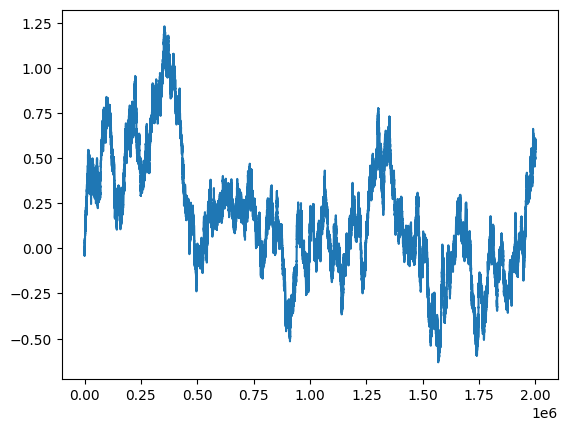

In [48]:
sampling_rate=2*1e6
sample_time=1/sampling_rate
N=2000000
def ou_noise(n, dt=1.0, mu=0.0, tau=20.0, sigma=1.0, x0=0.0, rng=None):
    rng = np.random.default_rng(rng)
    x = np.empty(n)
    x[0] = x0
    a = np.exp(-dt / tau)
    sd = sigma * np.sqrt(1 - a*a)
    for t in range(1, n):
        x[t] = mu + a*(x[t-1] - mu) + sd * rng.normal()
    return x
#I am setting tau to be 50ms
x = ou_noise(N, dt=sample_time, tau=100*1e-3, sigma=0.5)
plt.plot(x)
print(10*1e-3/sample_time)

In [49]:
Channel_dict={}
num_channels=10
actual_coh_time={}
for i in range(10):
    tau_I=random.randint(1,25)
    tau_Q=random.randint(1,25)
    Channel_dict[i]={'I':ou_noise(N,dt=sample_time,tau=tau_I*1e-3,sigma=0.5),'Q':ou_noise(N,dt=sample_time,tau=tau_Q*1e-3,sigma=0.5)}
    actual_coh_time[i]={'I':tau_I*1e-3/sample_time,'Q':tau_Q*1e-3/sample_time}
print(actual_coh_time)

{0: {'I': 4000.0000000000005, 'Q': 48000.0}, 1: {'I': 22000.0, 'Q': 4000.0000000000005}, 2: {'I': 42000.00000000001, 'Q': 18000.000000000004}, 3: {'I': 26000.000000000004, 'Q': 50000.00000000001}, 4: {'I': 28000.000000000004, 'Q': 42000.00000000001}, 5: {'I': 30000.0, 'Q': 24000.0}, 6: {'I': 48000.0, 'Q': 18000.000000000004}, 7: {'I': 24000.0, 'Q': 12000.0}, 8: {'I': 40000.0, 'Q': 46000.0}, 9: {'I': 12000.0, 'Q': 18000.000000000004}}


In [50]:
from numpy.fft import rfft, irfft

def autocorr_fft(x):
    x = np.asarray(x)
    x = x - x.mean()            # optional, improves robustness
    n = len(x)
    nfft = 1 << (2*n-1).bit_length()  # next pow2 for speed
    X = rfft(x, nfft)
    r = irfft(X * np.conj(X), nfft)[:n]   # non-negative lags
    r = r / (r[0] + 1e-20)      # normalize
    return r

def find_coh_time_fft(x, threshold=1e-2):
    r = autocorr_fft(x)
    # first lag where it drops below threshold
    idx = np.argmax(r <= threshold)  # returns 0 if first element meets
    if r[0] <= threshold:            # guard unlikely case
        return 0
    if idx == 0:                     # no drop found
        return len(r)                # cap at window length
    return idx

def find_coherence_time_per_channel(Wifi_symbol_dict):
    num_samples_per_coherence_detection=int(50*1e-3/sample_time) #We need 50ms data for this
    t_coh_dict={}
    for channel in Wifi_symbol_dict:
        t_coh_dict[channel]={'I':0,'Q':0}
        i=0
        number_samples=len(Wifi_symbol_dict[channel]['I'])
        t_coh_distribution_arr_I=[]
        t_coh_distribution_arr_Q=[]
        while num_samples_per_coherence_detection*i<number_samples:
            #normalised_I_samples=Wifi_symbol_dict[channel]['I']
            I_curr_samples=Wifi_symbol_dict[channel]['I'][i*num_samples_per_coherence_detection:(i+1)*num_samples_per_coherence_detection]
            Q_curr_samples=Wifi_symbol_dict[channel]['Q'][i*num_samples_per_coherence_detection:(i+1)*num_samples_per_coherence_detection]
            t_coh_distribution_arr_I.append(find_coh_time_fft(I_curr_samples))
            t_coh_distribution_arr_Q.append(find_coh_time_fft(Q_curr_samples))
            i+=1
            #print(i)
         #break
        t_coh_dict[channel]['I']=np.mean(t_coh_distribution_arr_I)
        t_coh_dict[channel]['Q']=np.mean(t_coh_distribution_arr_Q)
    
    return t_coh_dict


# #print(find_coh_time_fft(x[:100000]))
print(find_coherence_time_per_channel(Channel_dict))
dict_coherence_times = find_coherence_time_per_channel(Channel_dict)


{0: {'I': 9912.65, 'Q': 21706.8}, 1: {'I': 19468.2, 'Q': 10113.85}, 2: {'I': 19974.4, 'Q': 20194.6}, 3: {'I': 21033.1, 'Q': 22692.4}, 4: {'I': 19133.45, 'Q': 21127.0}, 5: {'I': 20503.9, 'Q': 19462.95}, 6: {'I': 24046.95, 'Q': 18765.75}, 7: {'I': 18516.0, 'Q': 18724.4}, 8: {'I': 22141.0, 'Q': 23998.75}, 9: {'I': 16492.75, 'Q': 15400.1}}


In [51]:
print(Channel_dict)

{0: {'I': array([ 0.        ,  0.00625383,  0.03100474, ..., -0.08426471,
       -0.08584368, -0.08997976]), 'Q': array([ 0.        ,  0.00128963, -0.00067518, ..., -0.30169429,
       -0.29825253, -0.29378342])}, 1: {'I': array([ 0.        ,  0.00496991,  0.00909378, ..., -0.45279372,
       -0.45596523, -0.45543364]), 'Q': array([ 0.00000000e+00, -6.66956702e-03, -8.42976380e-05, ...,
        1.84118576e-01,  1.77715107e-01,  1.58493218e-01])}, 2: {'I': array([0.        , 0.00028599, 0.0040871 , ..., 0.20576641, 0.19981087,
       0.202143  ]), 'Q': array([ 0.        ,  0.00268399,  0.01203451, ..., -0.05725884,
       -0.05786301, -0.05753669])}, 3: {'I': array([ 0.        ,  0.00396644, -0.00098446, ..., -0.06185949,
       -0.05819116, -0.0602576 ]), 'Q': array([ 0.00000000e+00, -1.28618678e-03, -1.27893682e-04, ...,
        2.99231944e-01,  3.03513508e-01,  3.01596902e-01])}, 4: {'I': array([ 0.        ,  0.00176643, -0.00110519, ..., -0.10324714,
       -0.10312935, -0.11144919]

In [52]:
# multi armed bandit to select next channel to scan
int(50*1e-3/sample_time)

100000

In [53]:
# each channel is one arm
num_channels = 10 # number of arms

arm_coherent_time = {}
arm_dwell_time = {}

arms_with_reward = {}
arm_last_played_time = {}
arm_coherent_time = {}

for i in range(num_channels):
    arms_with_reward[i] = 0
    arm_last_played_time[i] = 0
    arm_coherent_time[i] = min(dict_coherence_times[i]['I'], dict_coherence_times[i]['Q'])
    #arm_coherent_time[i] = random.randint(400, 1000)
    arm_dwell_time[i] = int(1e5 / arm_coherent_time[i]) # seems correct


In [28]:
# print(Channel_dict)
# print(len(Channel_dict))
# print(Channel_dict[9])
# print(len(Channel_dict[9]['I']))
# print(arm_coherent_time[1])

In [54]:
def get_reward(channel_chosen, current_sample_index, arm_last_played_time, arm_coherent_time):
    reward = (current_sample_index - arm_last_played_time[channel_chosen])/arm_coherent_time[channel_chosen]
    return (reward)

In [57]:
def selected_arm(epsilon):
    k = random.random()
    if (k < epsilon) : 
        next_arm = random.randint(0, num_channels-1)
    else:
        next_arm = max(arms_with_reward, key = arms_with_reward.get)
    return(next_arm)

# def selected_arm():
#     next_arm = max(arms_with_reward, key = arms_with_reward.get)
#     return(next_arm)

In [58]:
Wifi_output_samples={}
temp_output_samples = {}
for channel in Channel_dict:
    Wifi_output_samples[channel]={'I':[],'Q':[]}  # storing in the form of a list of elements (sample_num,value) for I and Q
epsilon = 0.5
# epsilon_decay = 0.995
total_samples = 2000000

current_sample_index = 0
while(current_sample_index<total_samples):

    temp_output_samples = {}

    for i in range(num_channels):
        arms_with_reward[i] = get_reward(i, current_sample_index, arm_last_played_time, arm_coherent_time)
    next_arm = selected_arm(epsilon)
    temp_output_samples[next_arm] = {}
    temp_output_samples[next_arm]['I'] = []
    temp_output_samples[next_arm]['Q'] = []
    arms_with_reward[next_arm] = 0
    for i in range(arm_dwell_time[next_arm]):
        if current_sample_index==total_samples-1:
            current_sample_index+=1
            break
        Wifi_output_samples[next_arm]['I'].append([current_sample_index, Channel_dict[next_arm]['I'][current_sample_index]])
        Wifi_output_samples[next_arm]['Q'].append([current_sample_index, Channel_dict[next_arm]['Q'][current_sample_index]])
        temp_output_samples[next_arm]['I'].append(Channel_dict[next_arm]['I'][current_sample_index])
        temp_output_samples[next_arm]['Q'].append(Channel_dict[next_arm]['Q'][current_sample_index])
        current_sample_index+=1   

    # print(temp_output_samples)

    coh_time_to_update = find_coherence_time_per_channel(temp_output_samples)
    arm_coherent_time[i] = min(coh_time_to_update[next_arm]['I'], coh_time_to_update[next_arm]['Q'])

    arm_last_played_time[next_arm] = current_sample_index

In [59]:
#print(arm_stddev)
#print(arm_mean_time)
for i in range(num_channels):
    print(Wifi_output_samples[i]['I'][:100])

[[27, -0.0006622789529449617], [28, 5.8949924564482355e-05], [29, -0.019536106163423255], [30, -0.020944564135294746], [31, -0.03356458289691987], [32, -0.03239566043477768], [33, -0.023028281351016762], [34, -0.02299049702173551], [35, -0.016418434167115553], [36, -0.007549126587558802], [42, -0.015551675613741177], [43, -0.020162836857350114], [44, -0.03215097647403552], [45, -0.04399435064844142], [46, -0.05165136216508672], [47, -0.06306807182230652], [48, -0.03224823187437502], [49, -0.012098855064013606], [50, 0.002746911447416036], [51, -0.001261923575967233], [160, -0.12000878890668046], [161, -0.11176095801507929], [162, -0.11832727578745907], [163, -0.11936062501385622], [164, -0.11269780200126488], [165, -0.10015919459408808], [166, -0.08844945620109498], [167, -0.09394947079342025], [168, -0.11315996623802649], [169, -0.11923416761459679], [256, -0.10341783829857833], [257, -0.10041589910979319], [258, -0.10774117979076782], [259, -0.09787938577789955], [260, -0.10061861299

In [33]:
print("HI")

HI


In [34]:
# def interpolate_smartly(data):
#     "The input data is of the form [index,value] we need to be able to diffrentiate between periodic and non periodic signals to do this we are just linearly interpolating in stft"
#     output_wifi_samples={}
#     for channel in data:
        
#         output_wifi_samples[channel]={'I':np.array([0 for i in range(2000000)]),'Q':np.array([0 for i in range(2000000)])}
#         I = np.zeros(2_000_000, dtype=np.float64)  # force float64
#         for cur_sample, val in data[channel]['I']:
#             idx = int(cur_sample)
#             I[idx] = float(val)
#         output_wifi_samples[channel]['I'] = I  # ensure the mutated array is stored

#         Q = np.zeros(2_000_000, dtype=np.float64)  # force float64
#         for cur_sample, val in data[channel]['Q']:
#             idx = int(cur_sample)
#             Q[idx] = float(val)
#         output_wifi_samples[channel]['Q'] = Q  # ensure the mutated array is stored

#     return output_wifi_samples


# Wifi_output_data_after_interpolation=interpolate_smartly(Wifi_output_samples)

# Per_channel_time_frequency_spectrum={}

# for channel in Wifi_symbols:
#     Per_channel_time_frequency_spectrum[channel]={}
#     I_f_t_spectrum=[]
#     Q_f_t_spectrum=[]
#     for i in range(num_fft-1):
#         #print((i+1)*num_samples_per_fft)
#         I_f_t_spectrum.append(abs(np.fft.fft(Wifi_output_data_after_interpolation[channel]['I'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
#         Q_f_t_spectrum.append(abs(np.fft.fft(Wifi_output_data_after_interpolation[channel]['Q'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
#     Per_channel_time_frequency_spectraum[channel]['I']=np.array(I_f_t_spectrum)
#     Per_channel_time_frequency_spectrum[channel]['Q']=np.array(Q_f_t_spectrum)



In [35]:
#plt.plot(Wifi_output_data_after_interpolation[1]['I'])
#print(Wifi_output_data_after_interpolation[1]['I'][0])

In [36]:
# fig,ax=plot_fft_rows_colormap_freq_on_y(Per_channel_time_frequency_spectrum[2]['I'])
# plt.show()

Doing Naive method

In [37]:
Wifi_naive_symbols={}
size_of_naive_samples_per_channel=100000

cur_num=0
for channel in Wifi_symbols:
    Wifi_naive_symbols[channel]={'I':[],'Q':[]}

while cur_num<total_samples:
    for channel in Wifi_symbols:
        for i in range(size_of_naive_samples_per_channel):
            Wifi_naive_symbols[channel]['I'].append((cur_num,Wifi_symbols[channel]['I'][cur_num]))
            Wifi_naive_symbols[channel]['Q'].append((cur_num,Wifi_symbols[channel]['Q'][cur_num]))
            cur_num+=1
        #cur_num+=size_of_naive_samples_per_channel
        if cur_num>=total_samples:
            break
#I = np.zeros(2_000_000, dtype=np.float64)  # force float64
print(Wifi_naive_symbols[1]['I'][:100])
#Wifi_naive_symbols[channel]['I'] = I  # ensure the mutated array is stored


NameError: name 'Wifi_symbols' is not defined

In [ ]:
Wifi_output_data_after_interpolation_naive=interpolate_smartly(Wifi_naive_symbols)

Per_channel_time_frequency_spectrum={}

for channel in Wifi_symbols:
    Per_channel_time_frequency_spectrum[channel]={}
    I_f_t_spectrum=[]
    Q_f_t_spectrum=[]
    for i in range(num_fft-1):
        #print((i+1)*num_samples_per_fft)
        I_f_t_spectrum.append(abs(np.fft.fft(Wifi_output_data_after_interpolation_naive[channel]['I'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
        Q_f_t_spectrum.append(abs(np.fft.fft(Wifi_output_data_after_interpolation_naive[channel]['Q'][i*num_samples_per_fft:(i+1)*num_samples_per_fft]))[:num_samples_per_fft//2])
    Per_channel_time_frequency_spectrum[channel]['I']=np.array(I_f_t_spectrum)
    Per_channel_time_frequency_spectrum[channel]['Q']=np.array(Q_f_t_spectrum)


fig,ax=plot_fft_rows_colormap_freq_on_y(Per_channel_time_frequency_spectrum[2]['I'])
plt.show()